<a href="https://colab.research.google.com/github/Eirinits/ML_project/blob/main/DT8807_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from math import sqrt

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

#from google.colab import files, drive
#import io
#drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
abundance_data = pd.read_csv('GSE106992.csv', sep="\t")
samples_metadata = pd.read_csv('metadata_GSE106992.tsv', sep="\t")

In [ ]:
%%capture
samples_metadata["Treatment_response"] = samples_metadata["treatment"] + "_" + samples_metadata['pasi75resp']
samples_metadata["Treatment_response"][samples_metadata['Treatment_response'].str.contains("Etanercept_No")] = "0"
samples_metadata["Treatment_response"][samples_metadata['Treatment_response'].str.contains("Etanercept_Yes")] = "1"
samples_metadata["Treatment_response"][samples_metadata['Treatment_response'].str.contains("Ustekinumab 90 mg_No")] = "2"
samples_metadata["Treatment_response"][samples_metadata['Treatment_response'].str.contains("Ustekinumab 90 mg_Yes")] = "3"

samples_metadata["pasi75resp"][samples_metadata['pasi75resp'].str.contains("Yes")] = "1"
samples_metadata["pasi75resp"][samples_metadata['pasi75resp'].str.contains("No")] = "0"

samples_metadata = samples_metadata[['refinebio_accession_code','treatment','pasi75resp','description','Treatment_response']]
#samples_metadata["refinebio_accession_code"] = samples_metadata.index
#samples_metadata

In [ ]:
# The following code prepares the data and metadata per sample type (psoriatic pre-treatment, healthy and psoriatic post-treatment)
LS0_metadata = samples_metadata.loc[samples_metadata['description'] == "LS Week 0"]
LS0_metadata["Treatment_response"] = LS0_metadata["description"].astype(str) + "_" + LS0_metadata["treatment"] + "_" + LS0_metadata['pasi75resp']
LS0_metadata["Treatment_response"][LS0_metadata['Treatment_response'].str.contains("LS Week 0_Etanercept_No")] = "0"
LS0_metadata["Treatment_response"][LS0_metadata['Treatment_response'].str.contains("LS Week 0_Etanercept_Yes")] = "1"
LS0_metadata["Treatment_response"][LS0_metadata['Treatment_response'].str.contains("LS Week 0_Ustekinumab 90 mg_No")] = "2"
LS0_metadata["Treatment_response"][LS0_metadata['Treatment_response'].str.contains("LS Week 0_Ustekinumab 90 mg_Yes")] = "3"
LS0_samples = list(LS0_metadata['refinebio_accession_code'])
LS0_samples.append('Gene')
LS0_data = abundance_data[abundance_data.columns & LS0_samples]

NL0_metadata = samples_metadata.loc[samples_metadata['description'] == "NL Week 0"]
NL0_metadata["Treatment_response"][NL0_metadata['Treatment_response'].str.contains("NL Week 0_Etanercept_No")] = "0"
NL0_metadata["Treatment_response"][NL0_metadata['Treatment_response'].str.contains("NL Week 0_Etanercept_Yes")] = "1"
NL0_metadata["Treatment_response"][NL0_metadata['Treatment_response'].str.contains("NL Week 0_Ustekinumab 90 mg_No")] = "2"
NL0_metadata["Treatment_response"][NL0_metadata['Treatment_response'].str.contains("NL Week 0_Ustekinumab 90 mg_Yes")] = "3"
NL0_samples = list(NL0_metadata['refinebio_accession_code'])
NL0_samples.append('Gene')
NL0_data = abundance_data[abundance_data.columns & NL0_samples]

LS12_metadata = samples_metadata.loc[samples_metadata['description'] == "LS Week 12"]
LS12_metadata["Treatment_response"][LS12_metadata['Treatment_response'].str.contains("LS Week 12_Etanercept_No")] = "0"
LS12_metadata["Treatment_response"][LS12_metadata['Treatment_response'].str.contains("LS Week 12_Etanercept_Yes")] = "1"
LS12_metadata["Treatment_response"][LS12_metadata['Treatment_response'].str.contains("LS Week 12_Ustekinumab 90 mg_No")] = "2"
LS12_metadata["Treatment_response"][LS12_metadata['Treatment_response'].str.contains("LS Week 12_Ustekinumab 90 mg_Yes")] = "3"
LS12_samples = list(LS12_metadata['refinebio_accession_code'])
LS12_samples.append('Gene')
LS12_data = abundance_data[abundance_data.columns & LS12_samples]

In [ ]:
#Select the psoriatic pre-treated samples to run the analysis & annotate samples

data_trans = LS0_data.T
data_trans['Sample'] = data_trans.index

annotated_samples_data = pd.merge(left=data_trans, right=LS0_metadata, left_on='Sample', right_on='refinebio_accession_code')
annotated_samples_data.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001631,ENSG00000002016,ENSG00000002079,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002726,ENSG00000002745,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003096,ENSG00000003137,ENSG00000003147,ENSG00000003249,ENSG00000003393,ENSG00000003400,ENSG00000003402,ENSG00000003436,ENSG00000003509,...,ENSG00000280401,ENSG00000280417,ENSG00000280420,ENSG00000280439,ENSG00000280670,ENSG00000280693,ENSG00000280721,ENSG00000280739,ENSG00000280832,ENSG00000280927,ENSG00000281097,ENSG00000281100,ENSG00000281103,ENSG00000281162,ENSG00000281189,ENSG00000281205,ENSG00000281332,ENSG00000281357,ENSG00000281358,ENSG00000281649,ENSG00000281732,ENSG00000281831,ENSG00000281912,ENSG00000281937,ENSG00000282408,ENSG00000282826,ENSG00000282863,ENSG00000282897,ENSG00000283103,ENSG00000283632,ENSG00000283703,ENSG00000283709,ENSG00000283849,ENSG00000284048,Sample,refinebio_accession_code,treatment,pasi75resp,description,Treatment_response
0,3.999118,0.209370,10.160230,2.021201,1.386422,2.916298,9.712554,7.187549,2.374178,0.837759,0.356520,1.842310,0.954295,0.663054,1.141921,0.221051,2.152776,3.810606,0.692962,0.139410,0.089701,14.893121,10.542693,0.401651,0.964132,1.455896,0.429034,6.194603,3.655489,4.933172,0.887988,0.657171,0.764128,0.710435,0.435048,1.513397,0.313394,1.390595,1.253426,2.175159,...,0.123386,0.592484,0.436612,0.317812,1.378492,8.429405,0.081031,0.199204,0.125209,-0.066513,0.441937,0.502358,0.647065,0.291434,0.088552,-0.086872,0.320418,-0.023456,0.112303,3.274127,0.109595,0.424235,0.264749,0.266996,0.529832,3.789498,0.449585,0.536265,3.974633,0.373342,0.660415,3.095794,0.117747,0.202803,GSM2859024,GSM2859024,Etanercept,1,LS Week 0,LS Week 0_Etanercept_1
1,3.387931,0.333162,9.979965,1.608231,1.651067,1.411241,9.778852,6.015243,1.714251,0.924688,0.351701,1.925300,1.339046,0.685188,1.993909,0.218585,1.561379,4.092296,0.646908,0.131093,0.398918,18.299376,20.004307,0.293589,0.466323,1.263459,0.624310,6.529169,3.017165,1.654127,1.666400,0.468437,0.710781,0.898941,0.450078,1.452174,0.295467,1.495649,1.134984,2.430605,...,0.143680,0.714254,0.299554,0.126452,3.560730,5.755833,0.195846,0.198311,0.051350,0.054533,0.335135,0.278506,0.390154,0.317330,0.222524,0.078260,0.480560,0.026301,0.240877,3.332095,0.061513,0.267352,0.283411,0.162890,0.512247,5.151493,0.285039,0.326211,5.082514,0.349273,0.478878,2.275275,0.110841,0.178581,GSM2859027,GSM2859027,Etanercept,0,LS Week 0,LS Week 0_Etanercept_0
2,4.278266,0.560401,8.440232,1.746125,1.008796,2.468296,10.586833,7.243020,1.777375,0.634345,0.333264,2.346962,0.981326,0.628807,2.086203,0.307896,1.504124,3.264349,0.540365,0.044027,0.422706,14.637146,14.559906,0.358683,0.711902,1.267411,0.368477,7.776684,3.952685,3.901264,1.291623,0.345845,0.589725,0.739983,0.483115,1.404462,0.260749,1.534621,1.098743,1.711601,...,0.067511,0.442190,0.379738,0.172556,3.195782,8.918114,0.367850,0.065611,0.107990,-0.068705,0.382095,0.406633,0.566721,0.306759,-0.010533,0.020647,0.406738,0.048936,0.294150,2.452836,0.163663,0.225927,0.258594,0.314253,0.315319,3.673298,0.219653,0.145258,4.962638,0.416791,0.207037,2.921586,0.131166,0.278244,GSM2859030,GSM2859030,Ustekinumab 90 mg,1,LS Week 0,LS Week 0_Ustekinumab 90 mg_1
3,4.183398,0.063336,10.087452,1.502457,1.457531,1.545818,4.866335,6.793379,2.140605,0.866381,0.391828,1.608231,1.089190,0.645440,1.539515,0.365622,2.339213,2.628347,0.602607,0.116594,0.458305,14.811855,16.200221,0.463337,0.733836,1.540907,0.618741,5.755833,3.401518,1.953581,2.072903,0.353748,0.686070,0.717154,0.560846,1.330769,0.357431,2.206082,0.839007,2.059263,...,0.053024,0.967382,0.190014,0.132941,0.983489,8.614004,0.289493,0.112238,0.078956,0.435626,0.405147,0.494774,0.7

In [ ]:
%%capture
# Select X (feautures) and y (target)
X = annotated_samples_data.loc[:, annotated_samples_data.columns.str.startswith('ENSG')]
X[X < 0] = 0
y = annotated_samples_data.loc[:, 'pasi75resp'] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3093: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


## Run and optimize SVM algorithm

              precision    recall  f1-score   support

           0       0.57      0.57      0.57         7
           1       0.77      0.77      0.77        13

    accuracy                           0.70        20
   macro avg       0.67      0.67      0.67        20
weighted avg       0.70      0.70      0.70        20



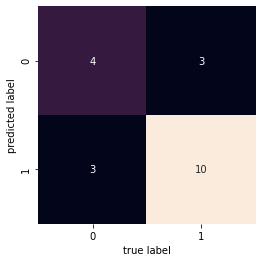

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify = y)
svc = SVC(kernel='rbf', class_weight='balanced', C=10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

[0.7, 0.65, 0.65, 0.65, 0.7, 0.65, 0.65, 0.65, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.7, 0.7, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.8, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.8, 0.8, 0.8, 0.8, 0.85, 0.85, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0

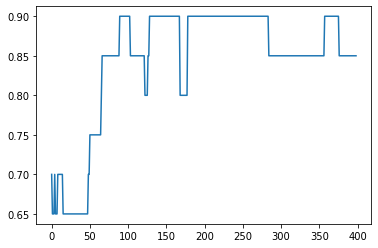

In [ ]:
accuracy_lst = []

for i in range(1,400):
  X_clf_sc = MinMaxScaler().fit_transform(X)
  selector = SelectKBest(chi2, k=i)
  selector.fit(X_clf_sc, y)
# Get columns to keep and create new dataframe with those only
  cols = selector.get_support(indices=True)
  features_df_new = X.iloc[:,cols]
  X_train, X_test, y_train, y_test = train_test_split(features_df_new, y, test_size=0.3, random_state=12345, stratify = y)
  svc = SVC(kernel='rbf', class_weight='balanced', C=10)
  svc.fit(X_train, y_train)
  y_pred = svc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  accuracy_lst.append(acc)
print(accuracy_lst)

plt.plot(accuracy_lst)
plt.show()


              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.92      0.92      0.92        13

    accuracy                           0.90        20
   macro avg       0.89      0.89      0.89        20
weighted avg       0.90      0.90      0.90        20



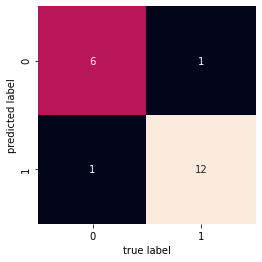

In [ ]:
X_clf_sc = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=95)
selector.fit(X_clf_sc, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]
X_train, X_test, y_train, y_test = train_test_split(features_df_new, y, test_size=0.3, random_state=12345, stratify = y)
svc = SVC(kernel='rbf', class_weight='balanced', C=10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
# Print features(genes) that best separate responders and non-responders.
features_df_new.columns.values

array(['ENSG00000094796', 'ENSG00000094841', 'ENSG00000099194',
       'ENSG00000100505', 'ENSG00000102055', 'ENSG00000108759',
       'ENSG00000108852', 'ENSG00000109705', 'ENSG00000110203',
       'ENSG00000111291', 'ENSG00000113205', 'ENSG00000117395',
       'ENSG00000119929', 'ENSG00000121578', 'ENSG00000126778',
       'ENSG00000127903', 'ENSG00000130035', 'ENSG00000130303',
       'ENSG00000131737', 'ENSG00000131738', 'ENSG00000132932',
       'ENSG00000135346', 'ENSG00000135443', 'ENSG00000136099',
       'ENSG00000139197', 'ENSG00000139648', 'ENSG00000141668',
       'ENSG00000142619', 'ENSG00000146856', 'ENSG00000149968',
       'ENSG00000153993', 'ENSG00000155090', 'ENSG00000157005',
       'ENSG00000159450', 'ENSG00000161850', 'ENSG00000163520',
       'ENSG00000164694', 'ENSG00000168016', 'ENSG00000170442',
       'ENSG00000170484', 'ENSG00000170523', 'ENSG00000171360',
       'ENSG00000171396', 'ENSG00000171446', 'ENSG00000171819',
       'ENSG00000173404', 'ENSG000001750

### Test SVM algorithm with different kernels

[[ 1  6]
 [ 1 12]]
              precision    recall  f1-score   support

           0       0.50      0.14      0.22         7
           1       0.67      0.92      0.77        13

    accuracy                           0.65        20
   macro avg       0.58      0.53      0.50        20
weighted avg       0.61      0.65      0.58        20



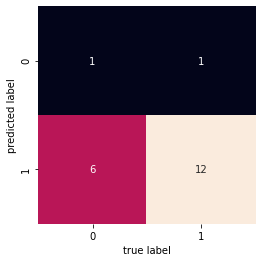

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

[[ 0  7]
 [ 0 13]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      1.00      0.79        13

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


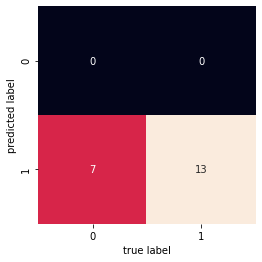

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid', degree=8)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Run and optimize KNN algorithm

Accuracy: 0.7 RMSE: 0.5477225575051661
Accuracy: 0.7
[[ 2  5]
 [ 1 12]]
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.71      0.92      0.80        13

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20



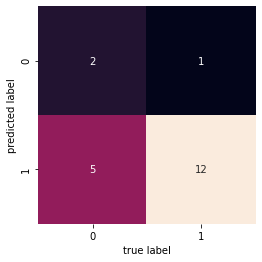

In [ ]:
parameters = {
    "n_neighbors": range(1, 36),
    "weights": ["uniform", "distance"],
}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)

gridsearch.best_params_

test_preds = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
test_rmse

print("Accuracy:",accuracy_score(y_test, test_preds_grid),"RMSE:",test_rmse)
print("Accuracy:",accuracy_score(y_test, test_preds))
print(confusion_matrix(y_test, test_preds))
print(classification_report(y_test, test_preds))
mat = confusion_matrix(y_test, test_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Run and optimize RF algorithm

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

parameters = {
    "n_estimators": range(1, 1000)
}

gridsearch = GridSearchCV(RandomForestClassifier(), parameters)
gridsearch.fit(X_train, y_train)

gridsearch.best_params_
test_preds = gridsearch.predict(X_test)

#test_preds = gridsearch.predict(X_test)

#clf=RandomForestClassifier(n_estimators=528)

#Train the model using the training sets 
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

Accuracy: 0.5


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(15,), random_state=1)

clf.fit(X_train, y_train)

y_pred_MLP = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred_MLP))

Accuracy: 0.5
